In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch import nn
import cv2
import numpy as np
import os
from pathlib import Path
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader
from pytorch_metric_learning import losses
from matplotlib import pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
root = Path().absolute().parent.parent / 'lmdb'
assert root.exists(), root.absolute()
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [3]:
!nvidia-smi

Tue Sep 24 22:57:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1B:00.0 Off |                  N/A |
| 27%   29C    P8              25W / 250W |  10381MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Simple CNN baseline

## Data tools

In [5]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [6]:
train_helper, val_helper = train_helper.train_val_split()

In [7]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [8]:
img, label = train_helper.get_item(42)

In [9]:
img.shape

(104, 79)

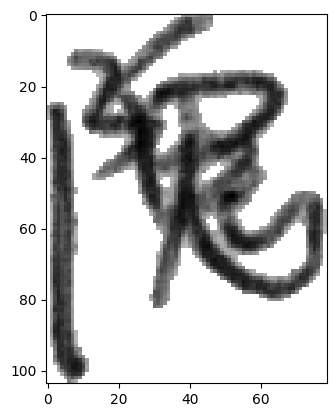

In [10]:
plt.imshow(img, cmap='gray')

In [11]:
class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        h, w = img.shape
        ratio = min(h, w) / max(h, w)
        h, w = tuple(map(int, (64, 64 * ratio)))
        delta_w = 64 - w
        delta_h = 64 - h
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)

        return (cv2.resize(img, (64, 64)) - 127.5) / 255., label


In [12]:
train_dataset = HWDBDataset(train_helper)
valid_dataset = HWDBDataset(val_helper)

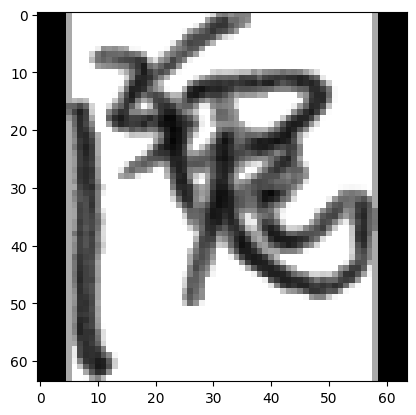

In [13]:
plt.imshow(train_dataset[42][0], cmap='gray')

In [14]:
train_dataset[42][0].shape

(64, 64)

In [15]:
train_dataset[42][0].dtype

dtype('float64')

In [16]:
train_loader = DataLoader(train_dataset, batch_size=512,  shuffle=True,  drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=False, drop_last=False)

## Model & training

In [17]:
num_classes = train_helper.vocabulary.num_classes()
embeddings_num = 512
num_classes, embeddings_num

(7330, 512)

In [18]:
model = torchvision.models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, embeddings_num)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = losses.ArcFaceLoss(num_classes=num_classes, embedding_size=embeddings_num).to(device)
loss_optimizer = torch.optim.Adam(params=loss_fn.parameters(), lr=0.01)

In [21]:
def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn, loss_optimizer):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).to(device))
        loss = loss_fn(logits, y.to(torch.long).to(device))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_optimizer.step()
        
def run_validation(val_loader: DataLoader, model: nn.Module, loss_fn, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            x = model(X.unsqueeze(1).to(torch.float32).to(device))
            logits = loss_fn.get_logits(x)
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


In [24]:
for epoch in range(5):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, valid_loader, model, optim, loss_fn, loss_optimizer)
    accuracy = run_validation(valid_loader, model, loss_fn)
    print(f'accuracy: {accuracy}')

Epoch 0:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:48<00:00,  2.90it/s]


accuracy: 0.908530597618091
Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:49<00:00,  2.88it/s]


accuracy: 0.9328662801791474
Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:48<00:00,  2.91it/s]


accuracy: 0.9415071772190584
Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:49<00:00,  2.88it/s]


accuracy: 0.9462557922709736
Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:49<00:00,  2.87it/s]

accuracy: 0.9498036794397844


## Evaluation

In [25]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [26]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [27]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        x = model(X.unsqueeze(1).to(torch.float32).to(device))
        logits = loss_fn.get_logits(x)
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:41<00:00,  9.24it/s]


In [28]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [29]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9327437822189426